In [2]:
from wfdb import rdsamp, rdrecord, rdann
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import numpy as np

In [3]:
signal, fields = rdsamp('data/drive15', channels=[0])

ecg = signal[:,0].flatten()
sampling_rate = 62
ecg_time = [i / sampling_rate for i in range(len(ecg))]

(72209, 7)
{'fs': 15.5, 'sig_len': 72209, 'n_sig': 7, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'bpm', 'mV', 'mV'], 'sig_name': ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP'], 'comments': []}
15.5


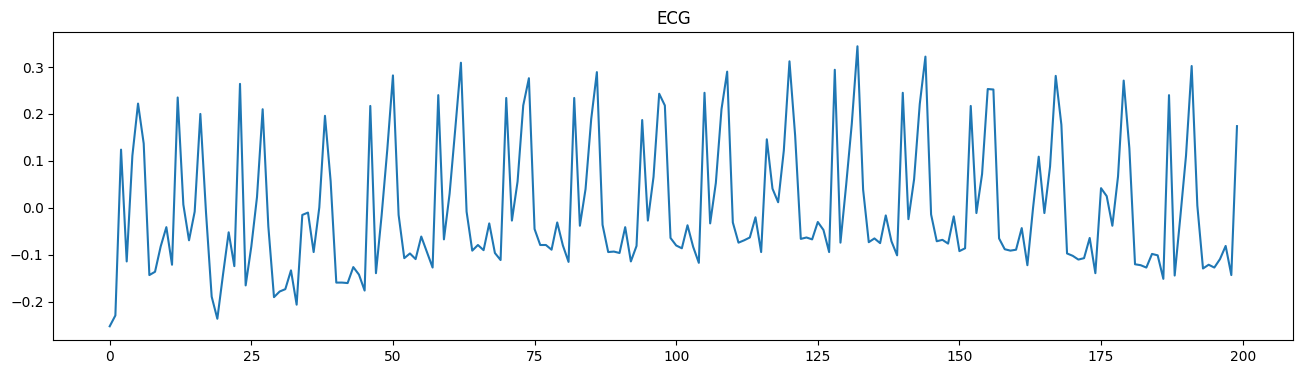

In [4]:
import wfdb
from wfdb import processing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure

path='data/drive15';
signals, fields = wfdb.rdsamp(path)
ECGnative=signals[:,0];

print(signals.shape)
print(fields)
print(fields["fs"])
plt.figure(figsize=(16, 4))
plt.plot(signals[:200,0])
plt.title(fields["sig_name"][0])
plt.show()

sampling_rate = fields["fs"]

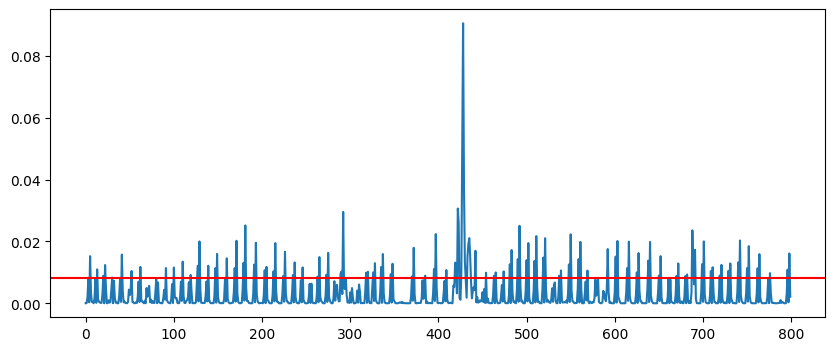

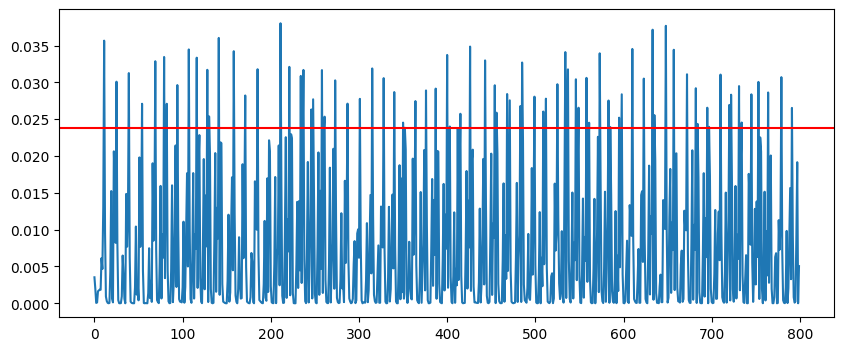

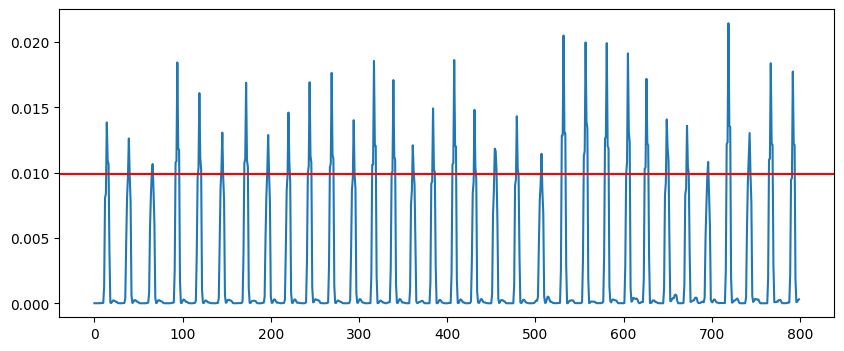

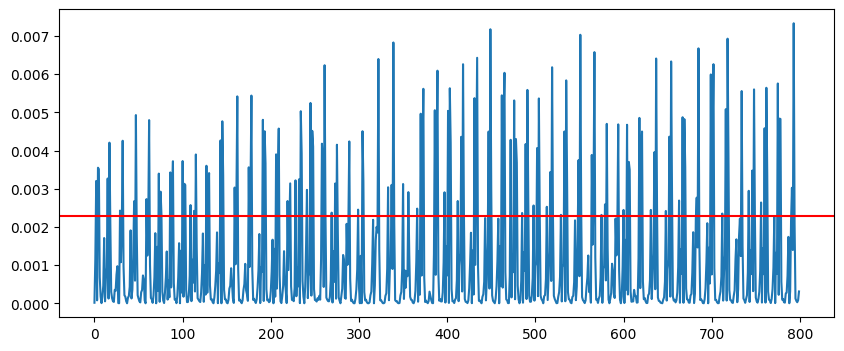

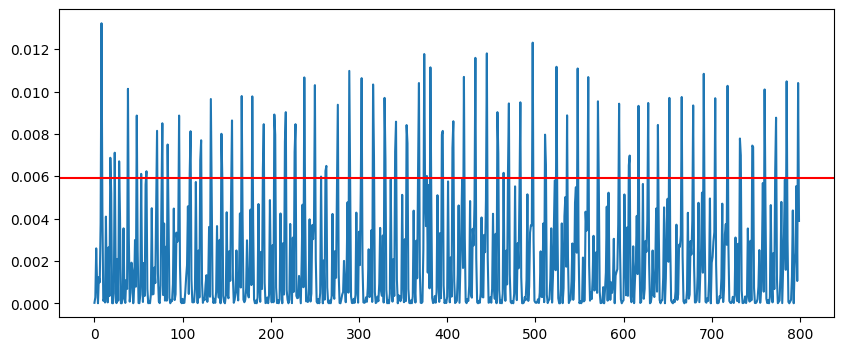

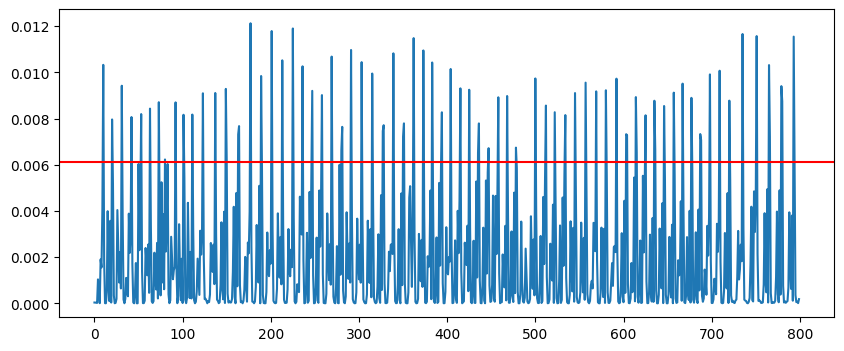

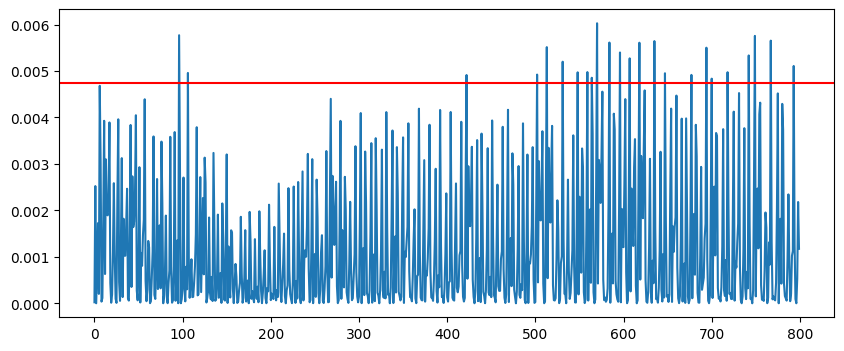

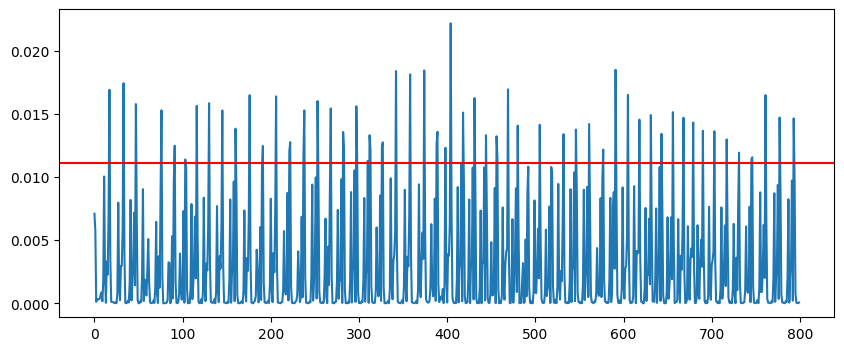

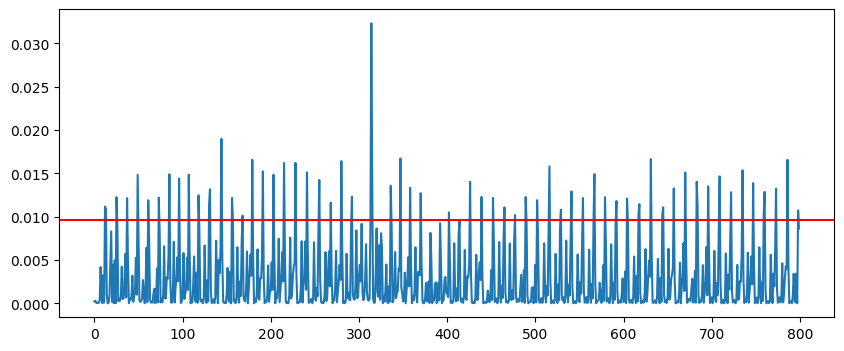

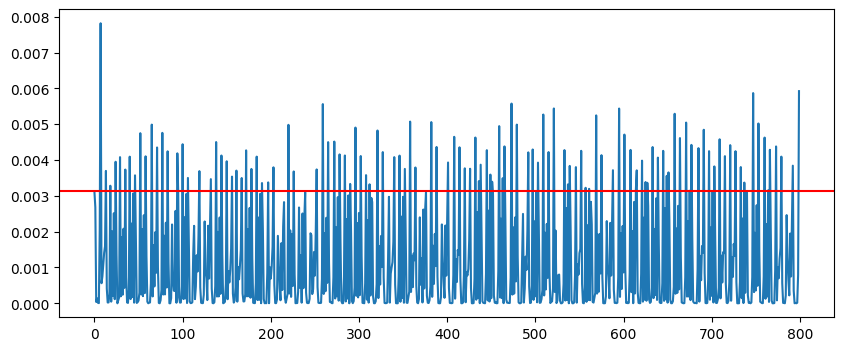

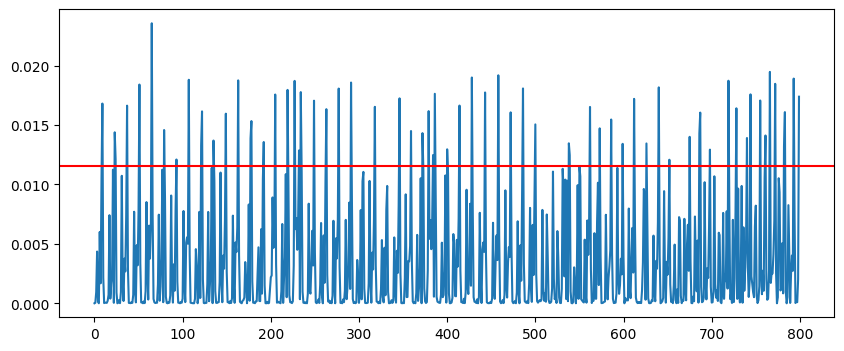

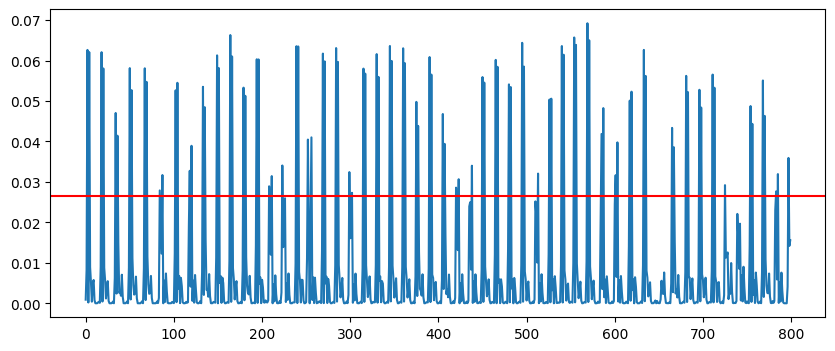

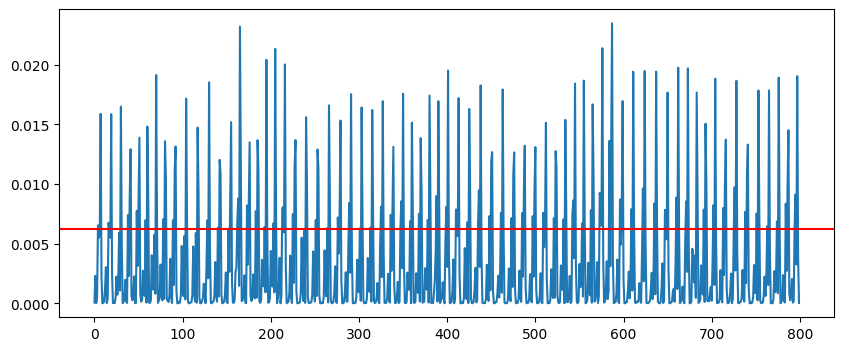

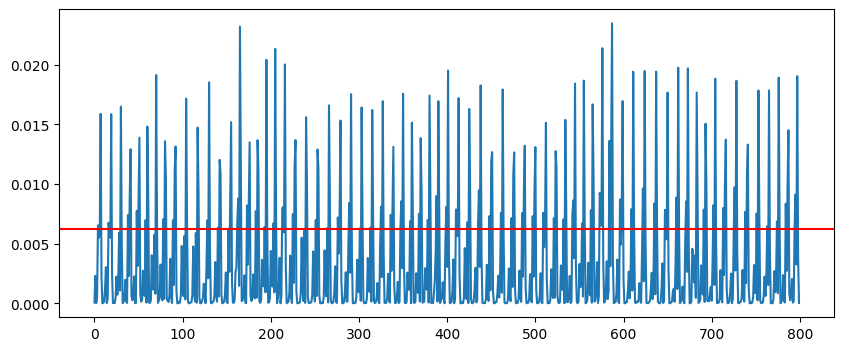

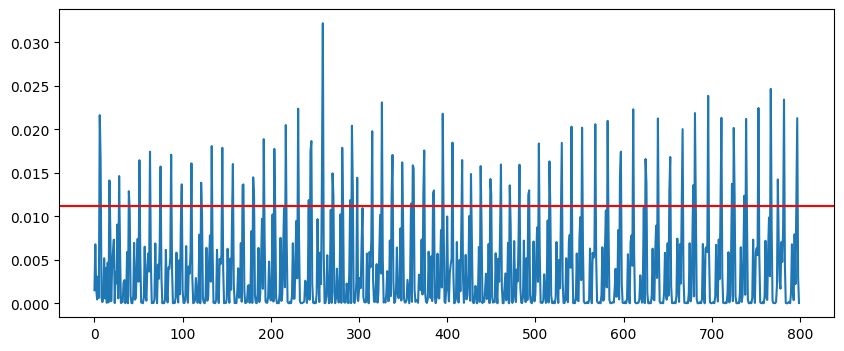

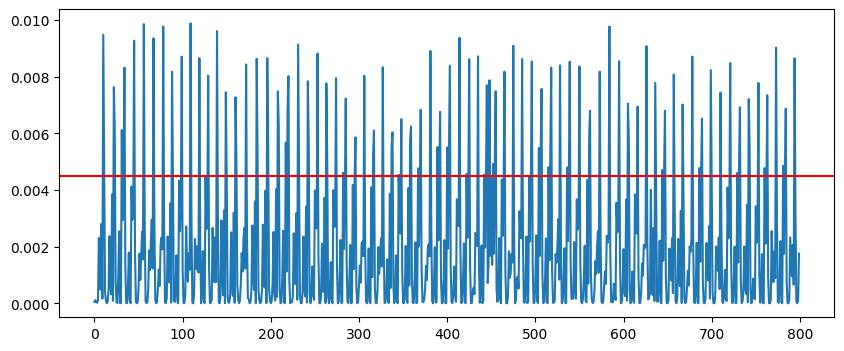

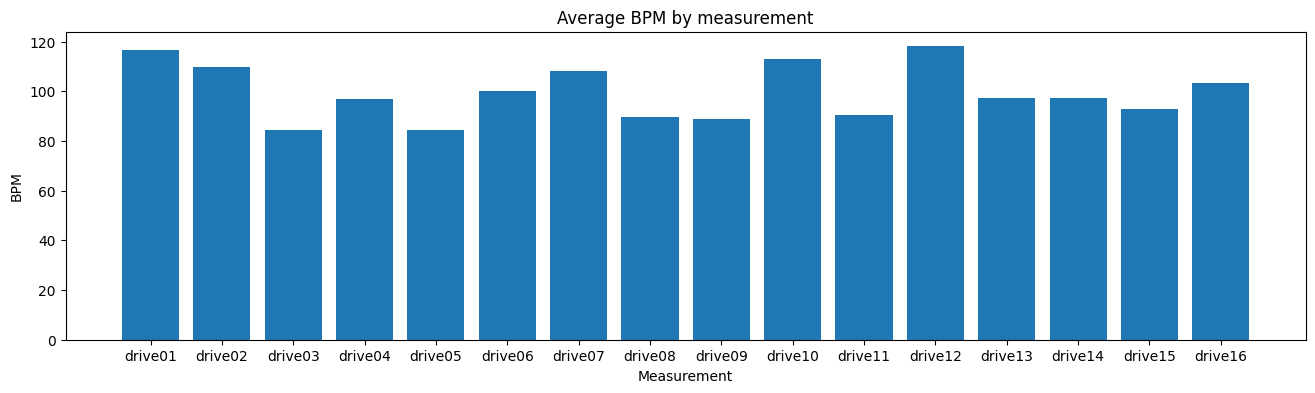

In [255]:
from scipy.signal import butter, filtfilt

def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    if normal_cutoff <= 0 or normal_cutoff >= 1:
        raise ValueError("Cutoff frequency is out of valid range. Please adjust it.")
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y

def enhance_qrs(ecg_signal, sampling_rate):
    derivative_kernel = np.array([-1.0, -2.0, 0, 2.0, 1.0]) / 8.0
    ecg_derivative = np.convolve(ecg_signal, derivative_kernel, mode='same')
    
    # Squaring to make all data points positive and emphasize peaks
    ecg_squared = ecg_derivative ** 2
    
    # Moving window integration to smooth out the signal
    window_size = int(0.12 * sampling_rate)  # Approx. width of QRS complex
    window = np.ones(window_size) / window_size
    ecg_smooth = np.convolve(ecg_squared, window, mode='same')

    return ecg_smooth

def find_peaks(ecg, sampling_rate, threshold=0.5, print_plot=False):
    convolved_ecg = enhance_qrs(ecg, sampling_rate)

    threshold = np.percentile(convolved_ecg, 87)

    if print_plot:
        plt.figure(figsize=(10, 4))    
        plt.plot(convolved_ecg[0:800])
        plt.axhline(threshold, color="r")
        plt.show()

    peaks = []
    for i in range(1, len(convolved_ecg) - 1):
        if convolved_ecg[i] > threshold and convolved_ecg[i] > convolved_ecg[i - 1] and convolved_ecg[i] > convolved_ecg[i + 1]:
            peaks.append(i)
    return np.array(peaks)

def compute_hr_from_ecg(ecg, sampling_rate, print_plot=False):
    # Preprocessing
    Qa = np.percentile(ecg, 0)
    Qb = np.percentile(ecg, 90)
    IQR = Qb - Qa

    # Define outliers
    outliers = (ecg < (Qa - 1.5 * IQR)) | (ecg > (Qb + 1.5 * IQR))

    ecg = ecg[~outliers]
    ecg = butter_highpass_filter(ecg, 0.5, sampling_rate)

    # R peak detection
    peaks = find_peaks(ecg, sampling_rate=sampling_rate, print_plot=print_plot)
 
    # Compute heart rate
    if len(peaks) > 1:
        peak_intervals = np.diff(peaks) / sampling_rate
        avg_heart_rate = 60 / np.mean(peak_intervals)
    else:
        avg_heart_rate = 0
    
    return avg_heart_rate, peaks, ecg

# for every drive from 01 to 15
measurement_hr = []
measurement_name = []
for i in range(1, 17):
    # define the path, if the number is less than 10, add a 0 before the number
    path=f'data/drive{0 if i < 10 else ""}{i}'
    signals, fields = wfdb.rdsamp(path)
    ecg=signals[:,0]
    sampling_rate = fields["fs"]

    avg_heart_rate, peaks, ecg = compute_hr_from_ecg(ecg, sampling_rate, print_plot=True)
    measurement_hr.append(avg_heart_rate)
    measurement_name.append(f'drive{"0" if i < 10 else ""}{i}')

plt.figure(figsize=(16, 4))
plt.bar(measurement_name, measurement_hr)
plt.title("Average BPM by measurement")
plt.ylabel("BPM")
plt.xlabel("Measurement")
plt.show()

In [6]:
mit_signals = []
for file in ["16265", "16272", "16273", "16420", "16483", "16539", "16773", "16786", "16795"]:
  signal, info = rdsamp("mit-bih/" + file, channels=None)
  ann = rdann("mit-bih/" + file, extension="atr")
  sr = info["fs"]
  signal = signal[:, 0]

  mit_signals.append((signal, sr, ann))

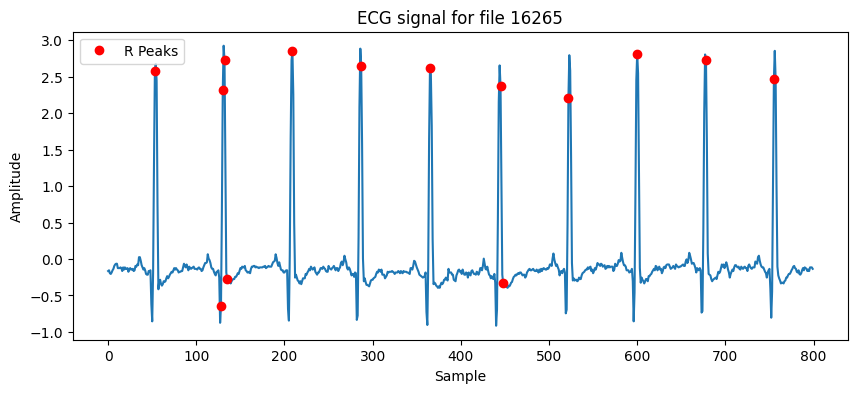

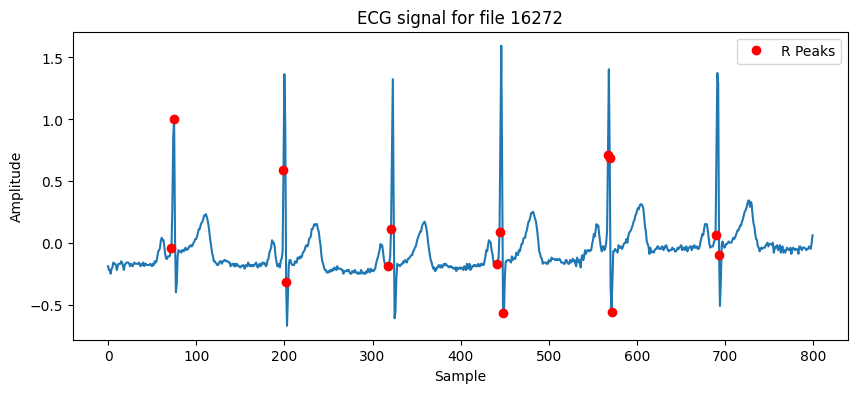

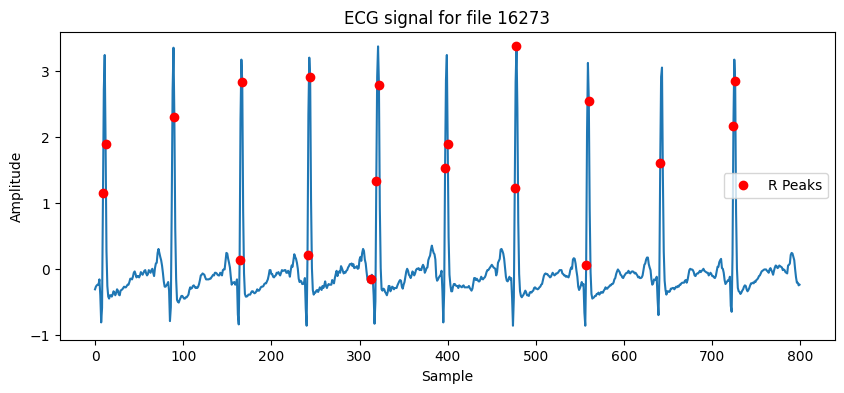

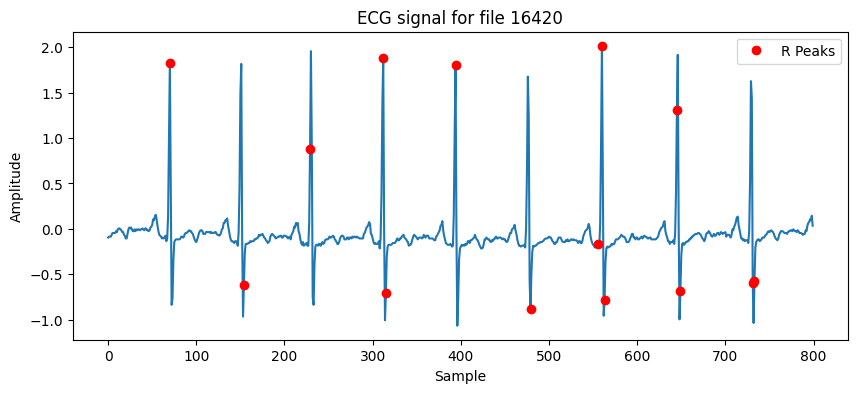

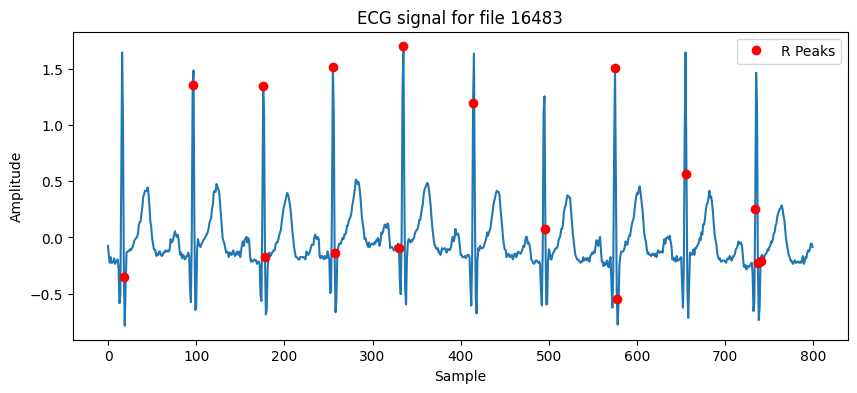

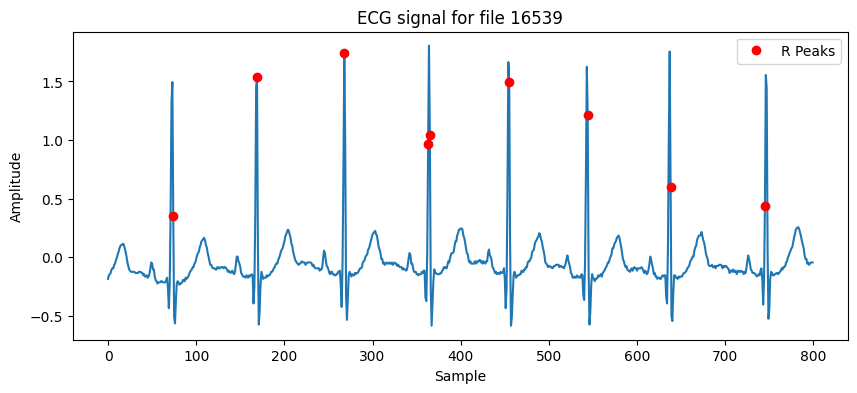

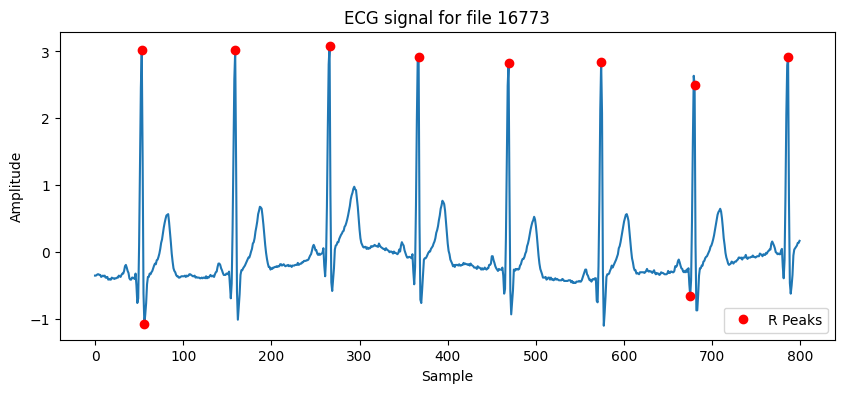

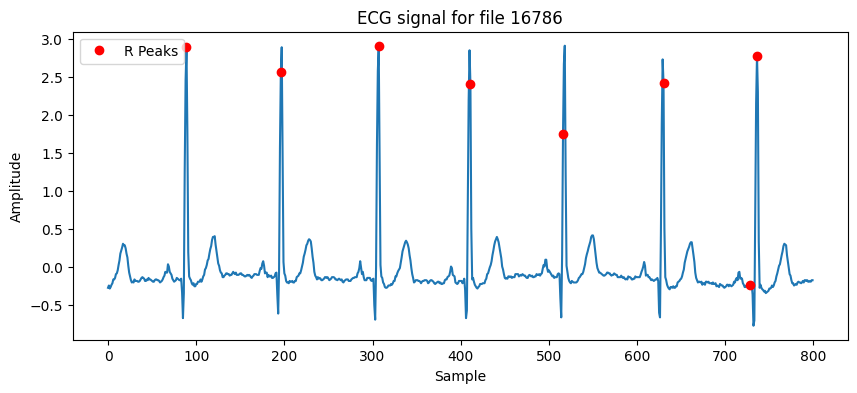

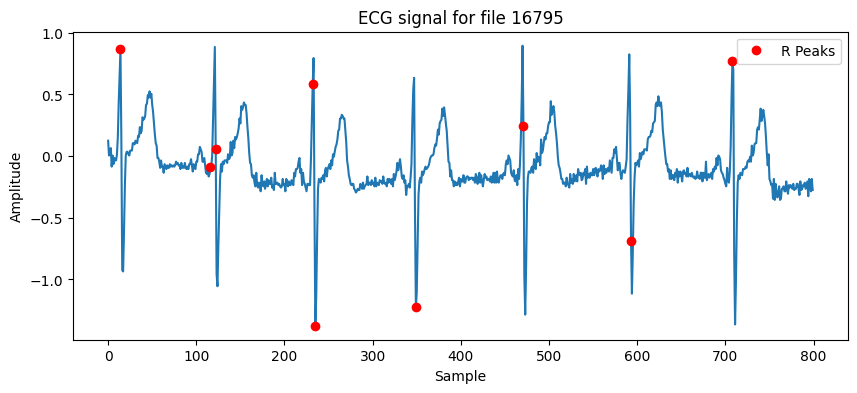

In [7]:
mit_hr = []
mit_ann_hr = []
mit_name = []
for (signal, sr, ann) in mit_signals:
  avg_heart_rate, peaks, ecg = compute_hr_from_ecg(signal, sr)
  mit_hr.append(avg_heart_rate)
  mit_name.append(ann.record_name)

  duration_in_seconds = len(signal) / sr
  num_beats = len(ann.sample)
  ann_hr = (num_beats / duration_in_seconds) * 60
  mit_ann_hr.append(ann_hr)

  plt.figure(figsize=(10, 4))
  plt.plot(signal[:800])
  
  peaks_within_range = [peak for peak in peaks if peak < 800]
  
  plt.plot(peaks_within_range, signal[peaks_within_range], 'ro', label='R Peaks')
  plt.title(f"ECG signal for file {ann.record_name}")
  plt.xlabel("Sample")
  plt.ylabel("Amplitude")
  plt.legend()
  plt.show()

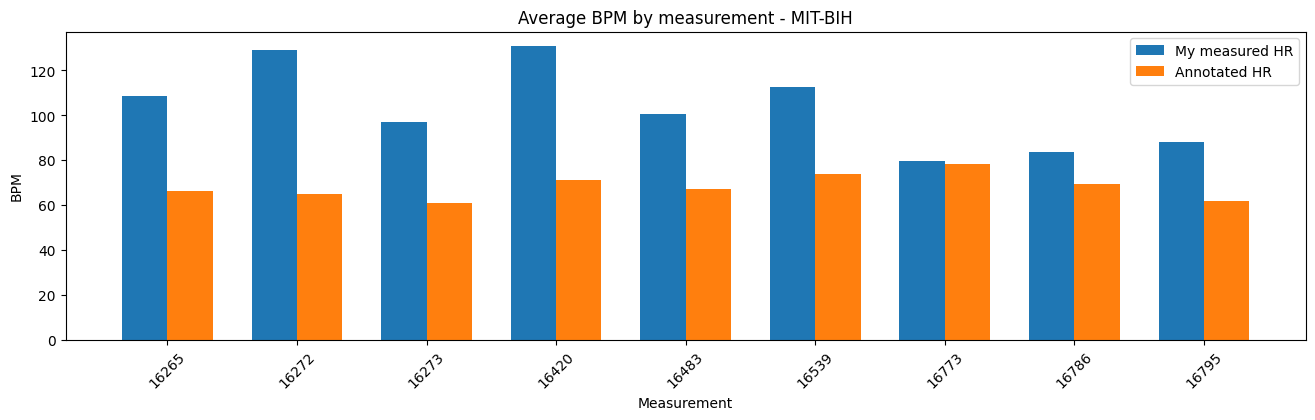

In [8]:
n_groups = len(mit_name)

# Create figure and axis
plt.figure(figsize=(16, 4))

# Set the positions of the bars on the x-axis and their width
index = np.arange(n_groups)
bar_width = 0.35

# Plotting both sets of bars
plt.bar(index, mit_hr, bar_width, label='My measured HR')
plt.bar(index + bar_width, mit_ann_hr, bar_width, label='Annotated HR')

# Adding labels, title, and custom x-axis tick labels, etc.
plt.xlabel('Measurement')
plt.ylabel('BPM')
plt.title('Average BPM by measurement - MIT-BIH')
plt.xticks(index + bar_width / 2, mit_name, rotation=45)  # Align ticks in the middle of the grouped bars
plt.legend()

# Show the plot
plt.show()

# Korelace EKG signálů

Dominant sampling rate: 15.5 Hz
Sampling rates: [15.5, 15.5, 31, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5]


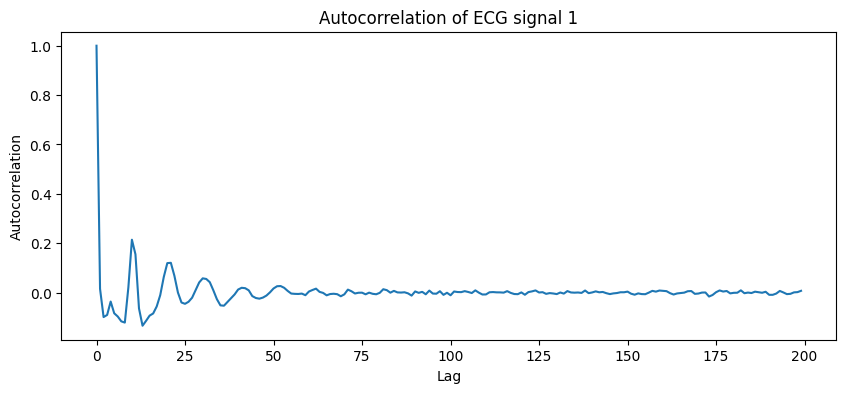

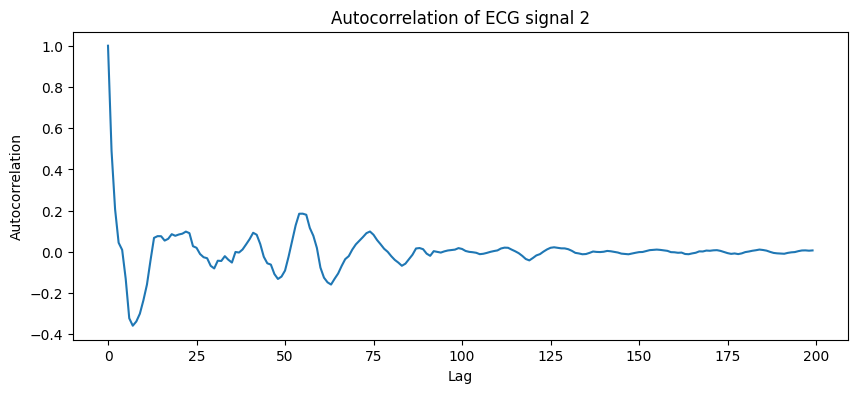

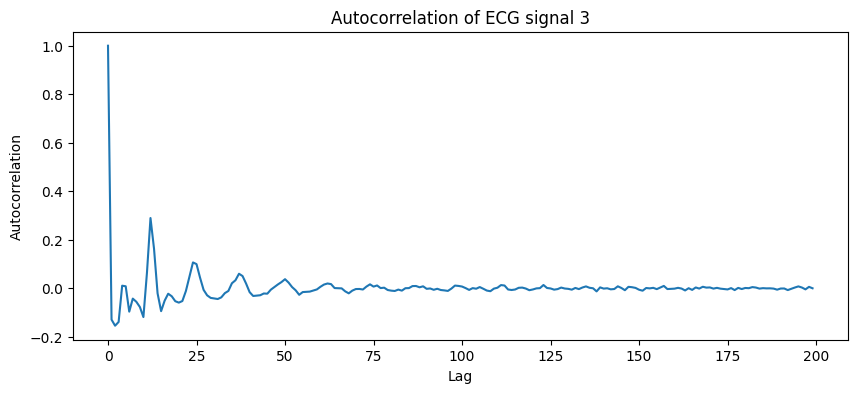

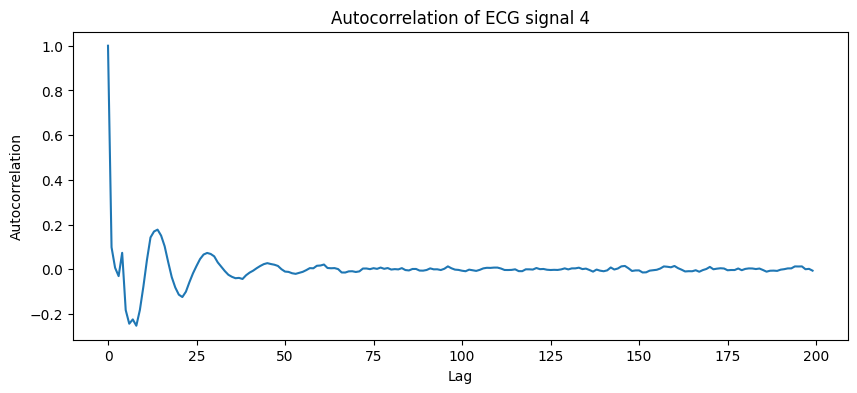

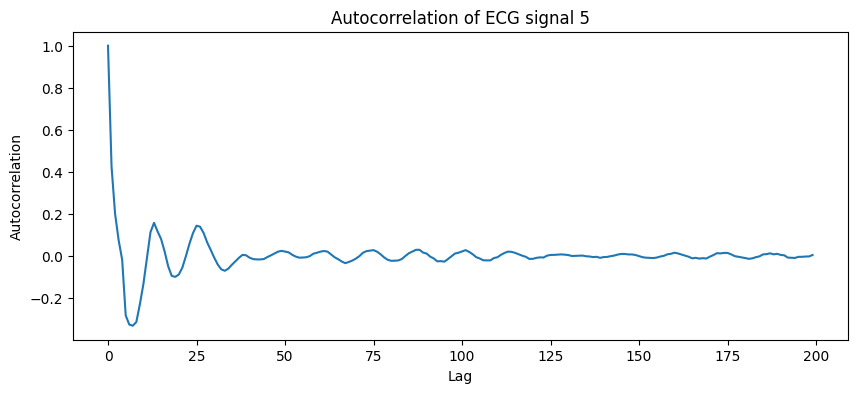

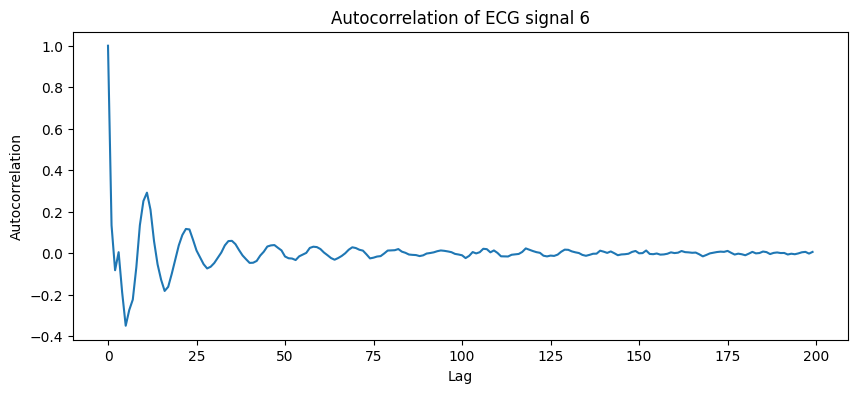

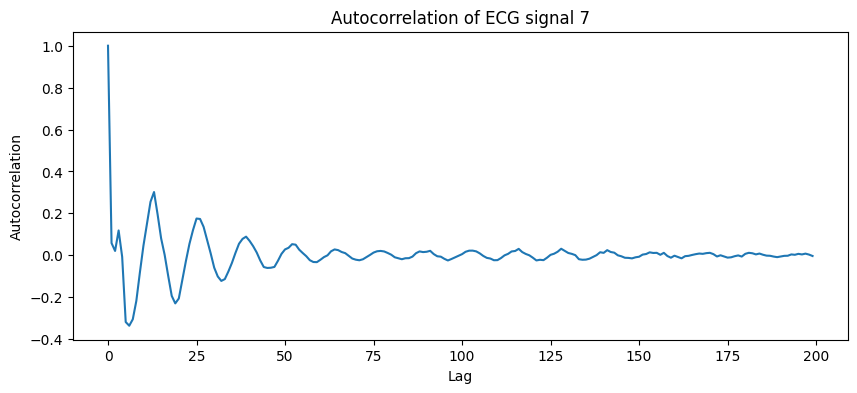

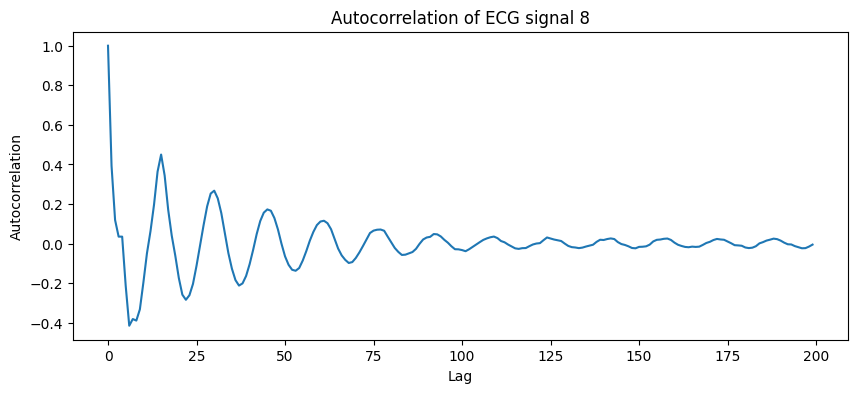

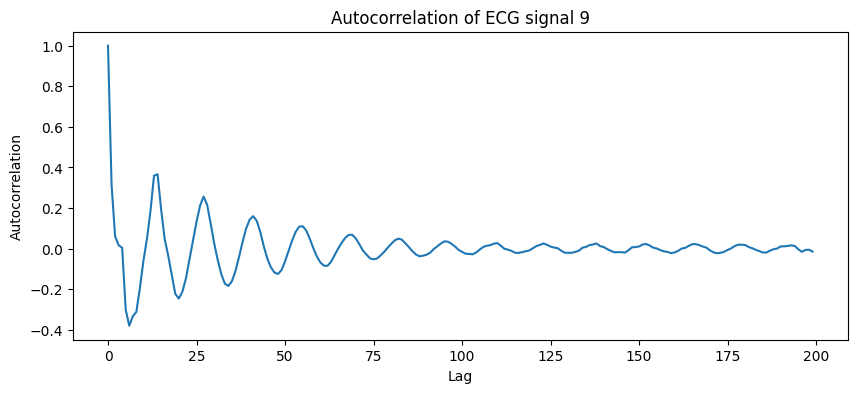

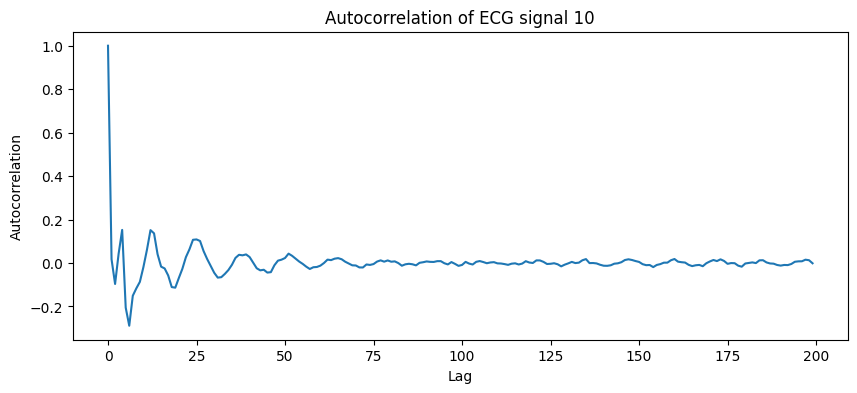

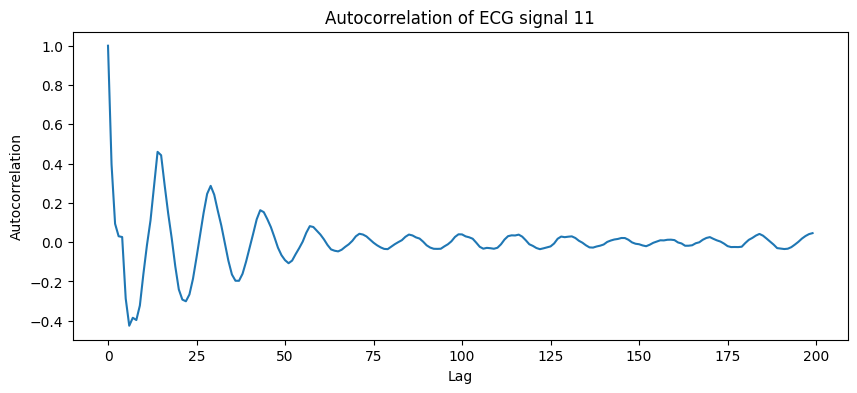

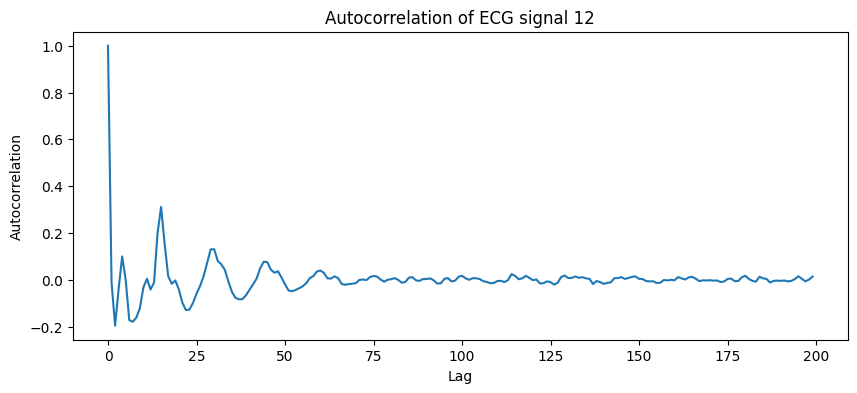

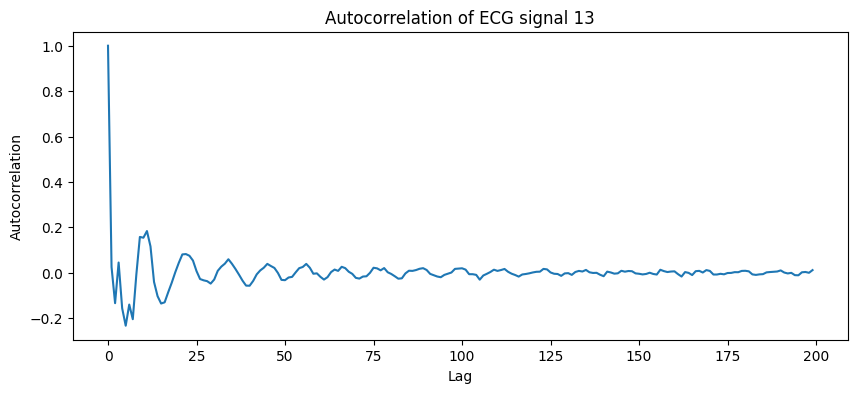

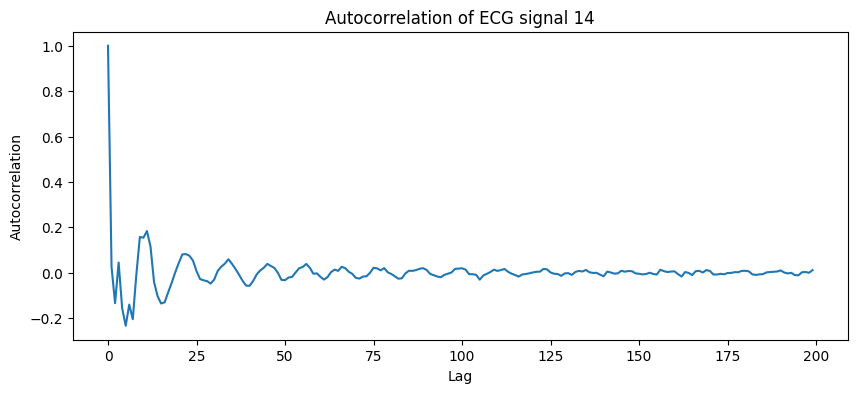

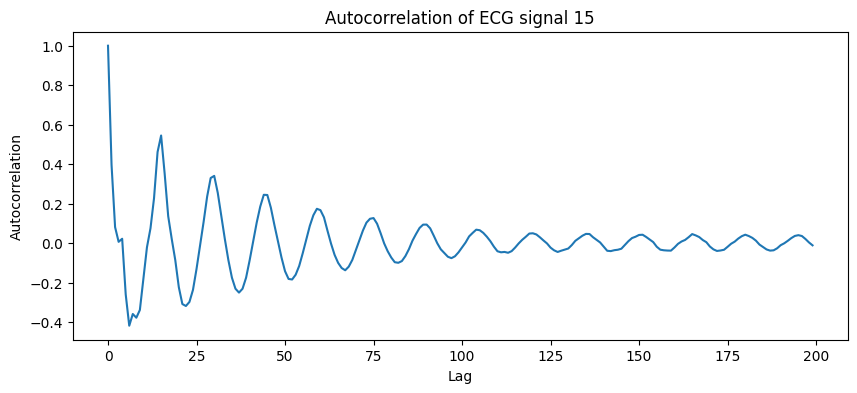

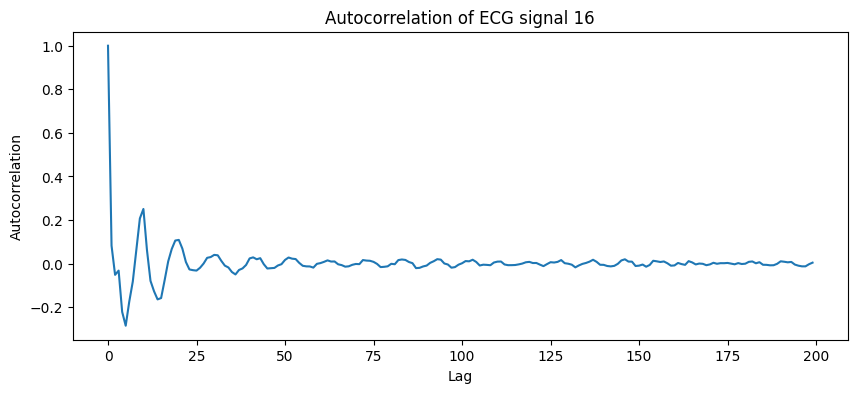

In [30]:
from scipy.signal import resample, decimate, correlate
from scipy.stats import mode

ecgs = []
for i in range(1, 17):
  path=f'data/drive{0 if i < 10 else ""}{i}'
  signals, fields = wfdb.rdsamp(path)
  ecg=signals[:,0]
  sampling_rate = fields["fs"]
    # Preprocessing
  Qa = np.percentile(ecg, 0)
  Qb = np.percentile(ecg, 90)
  IQR = Qb - Qa

  # Define outliers
  outliers = (ecg < (Qa - 1.5 * IQR)) | (ecg > (Qb + 1.5 * IQR))

  ecg = ecg[~outliers]
  ecg = butter_highpass_filter(ecg, 0.5, sampling_rate)
  ecgs.append((signals[:,0], sampling_rate))

# find the dominant sampling rate
sampling_rates = [i[1] for i in ecgs]
dom_sr, _ = mode(sampling_rates)
print('Dominant sampling rate: {} Hz'.format(dom_sr))
print("Sampling rates: {}".format(sampling_rates))

# resample the ECG signals to dominant sampling rate
resampled_ecgs = []
for (ecg, sr) in ecgs:
  duration = len(ecg) / sr
  target_samples = int(duration * dom_sr)
  resampled_ecg = resample(ecg, target_samples)
  resampled_ecgs.append(resampled_ecg)

# find the first r peak in each ECG
for i, resampled_ecg in enumerate(resampled_ecgs):
  # use the compute_hr_from_ecg function to find the first r peak (there is pre-processing involved in this function)
  _, peaks, ecg = compute_hr_from_ecg(resampled_ecg, dom_sr, print_plot=False)

  # find the first r peak that is bigger than adjacent peaks
  first_peak = None
  for j, peak in enumerate(peaks):
    if peak == 0 or peak == len(ecg) - 1:
      continue
    if j == 0 or j == len(peaks) - 1:
      continue
    if ecg[peak] > ecg[peaks[j - 1]] and ecg[peak] > ecg[peaks[j + 1]]:
      first_peak = peak
      break

  # go left from the peak and find the true peak of the signal
  true_peak = first_peak
  for j in range(first_peak, 0, -1):
    if ecg[j] > ecg[j - 1]:
      true_peak = j
    else:
      break

  # cut the signal from true peak to end
  resampled_ecgs[i] = ecg[true_peak:]
  
# plot the autocorrelation of the signals
for i, resampled_ecg in enumerate(resampled_ecgs):
  # calculate the autocorrelation of the signal
  autocorr = correlate(resampled_ecg, resampled_ecg, mode='full')
  autocorr = autocorr[len(autocorr) // 2:] / np.max(autocorr)

  # plot the autocorrelation
  plt.figure(figsize=(10, 4))
  plt.plot(autocorr[:200])
  plt.title(f"Autocorrelation of ECG signal {i + 1}")
  plt.xlabel("Lag")
  plt.ylabel("Autocorrelation")
  plt.show()


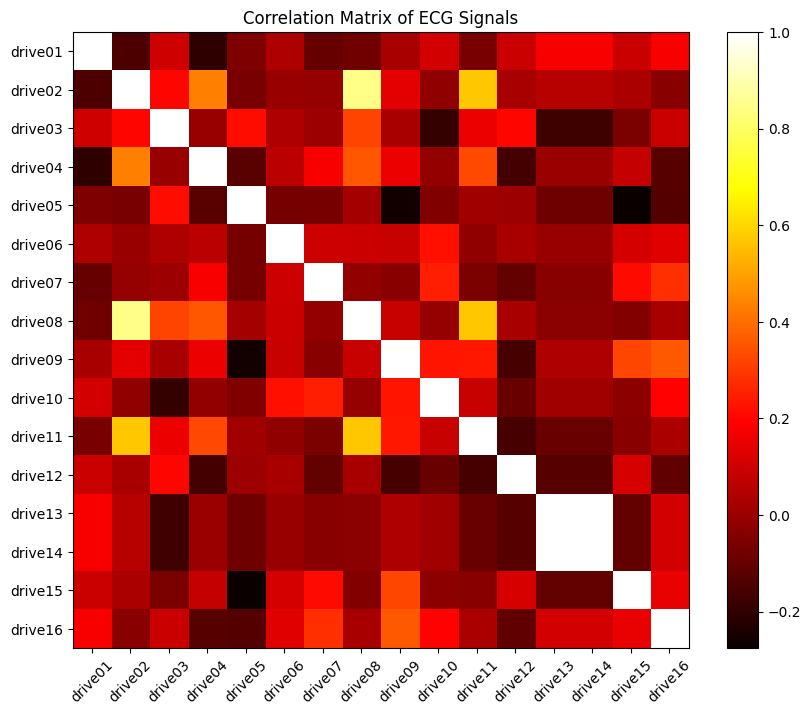

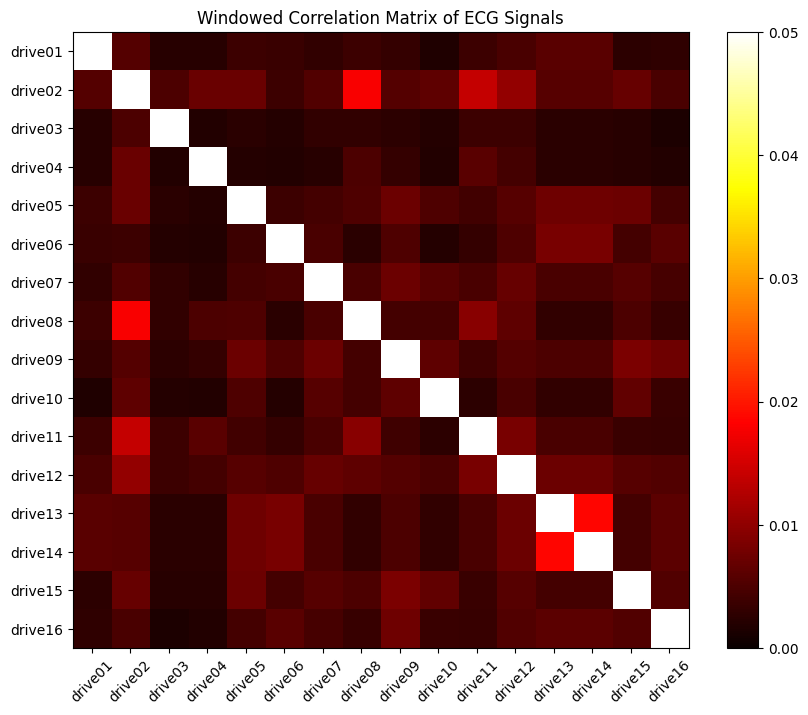

In [104]:
def centralize_signal(signal):
    return signal - np.mean(signal) / np.std(signal)

def calculate_correlation(signal1, signal2, length):
    min_length = min(len(signal1), len(signal2), length)

    signal1_centered = centralize_signal(signal1)
    signal2_centered = centralize_signal(signal2)

    signal1 = signal1_centered[:min_length]
    signal2 = signal2_centered[:min_length]
    
    correlation = np.correlate(signal1, signal2, mode='valid')
    correlation_normalized = correlation / (np.linalg.norm(signal1) * np.linalg.norm(signal2))

    return np.mean(correlation_normalized)

def calculate_correlation_windowed(signal1, signal2, length):
    min_length = min(len(signal1), len(signal2), length)

    signal1_centered = centralize_signal(signal1)
    signal2_centered = centralize_signal(signal2)

    signal1 = signal1_centered
    signal2 = signal2_centered[:min_length]
    
    num_windows = min(len(signal1), len(signal2)) // length
    
    correlation_values = []
    
    for i in range(num_windows):
        start = i * length
        end = start + length
        window1 = signal1[start:end]
        window2 = signal2[start:end]
        
        cross_corr = np.correlate(window1, window2, mode='full')
        
        max_corr = np.max(np.abs(cross_corr))
        
        normalized_corr = max_corr / length
        correlation_values.append(normalized_corr)
    
    avg_correlation = np.mean(correlation_values)
    return avg_correlation

correlation_length = int(dom_sr * 5)  # 5 second window

num_signals = len(resampled_ecgs)
correlation_matrix = np.zeros((num_signals, num_signals))
correlation_matrix_windowed = np.zeros((num_signals, num_signals))

for i in range(num_signals):
    for j in range(i, num_signals):
        if i == j:
            correlation_matrix[i, j] = 1
            correlation_matrix_windowed[i, j] = 1
        else:
            corr = calculate_correlation(resampled_ecgs[i], resampled_ecgs[j], correlation_length)
            corr_windowed = calculate_correlation_windowed(resampled_ecgs[i], resampled_ecgs[j], correlation_length)
            correlation_matrix[i, j] = corr
            correlation_matrix[j, i] = corr
            correlation_matrix_windowed[i, j] = corr_windowed
            correlation_matrix_windowed[j, i] = corr_windowed

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.title("Correlation Matrix of ECG Signals")
plt.colorbar()
titles = [f"drive{i:02}" for i in range(1, num_signals + 1)]
plt.xticks(ticks=np.arange(num_signals), labels=titles, rotation=45)
plt.yticks(ticks=np.arange(num_signals), labels=titles)
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix_windowed, cmap='hot', interpolation='nearest', vmin=0, vmax=.05)
plt.title("Windowed Correlation Matrix of ECG Signals")
plt.colorbar()
plt.xticks(ticks=np.arange(num_signals), labels=titles, rotation=45)
plt.yticks(ticks=np.arange(num_signals), labels=titles)
plt.show()

In [109]:
upper_triangle = np.triu_indices(num_signals, k=1)
correlations = correlation_matrix[upper_triangle]

sorted_correlations = np.sort(np.unique(correlations))
second_highest_correlation = sorted_correlations[-2]
lowest_correlation = sorted_correlations[0]

second_most_similar_pair = next((i, j) for i in range(num_signals) for j in range(i + 1, num_signals) if correlation_matrix[i, j] == second_highest_correlation)
lowest_correlation_pair = next((i, j) for i in range(num_signals) for j in range(i + 1, num_signals) if correlation_matrix[i, j] == lowest_correlation)

# create the correlation function
similar_correlation_function = np.correlate(resampled_ecgs[second_most_similar_pair[0]], resampled_ecgs[second_most_similar_pair[1]], mode='full')
similar_correlation_function = similar_correlation_function / (np.linalg.norm(resampled_ecgs[second_most_similar_pair[0]]) * np.linalg.norm(resampled_ecgs[second_most_similar_pair[1]]))

non_similar_correlation_function = np.correlate(resampled_ecgs[lowest_correlation_pair[0]], resampled_ecgs[lowest_correlation_pair[1]], mode='full')
non_similar_correlation_function = non_similar_correlation_function / (np.linalg.norm(resampled_ecgs[lowest_correlation_pair[0]]) * np.linalg.norm(resampled_ecgs[lowest_correlation_pair[1]]))

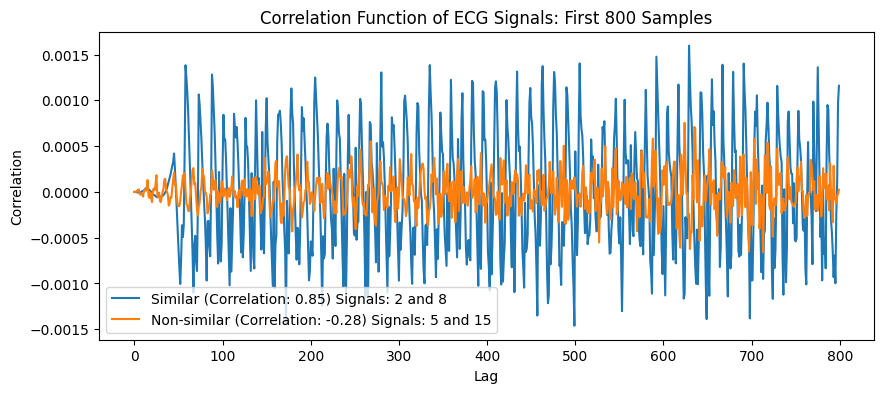

In [122]:
plt.figure(figsize=(10, 4))
plt.plot(similar_correlation_function[:800], label=f"Similar (Correlation: {second_highest_correlation:.2f}) Signals: {second_most_similar_pair[0] + 1} and {second_most_similar_pair[1] + 1}")
plt.plot(non_similar_correlation_function[:800], label=f"Non-similar (Correlation: {lowest_correlation:.2f}) Signals: {lowest_correlation_pair[0] + 1} and {lowest_correlation_pair[1] + 1}")
plt.title(f"Correlation Function of ECG Signals: First 800 Samples")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.legend()
plt.show()

## Klasifikace EMG signálů

In [241]:
emgs = {}
for i in range(1, 17):
    # define the path, if the number is less than 10, add a 0 before the number
    path=f'data/drive{0 if i < 10 else ""}{i}'
    signals, fields = wfdb.rdsamp(path)
    if fields["sig_name"][1] != "EMG":
        continue
    emg=signals[:,1]
    # normalize the signal
    emg = (emg - np.mean(emg)) / np.std(emg)
    sampling_rate = fields["fs"]
    emgs[i] = (emg, sampling_rate)

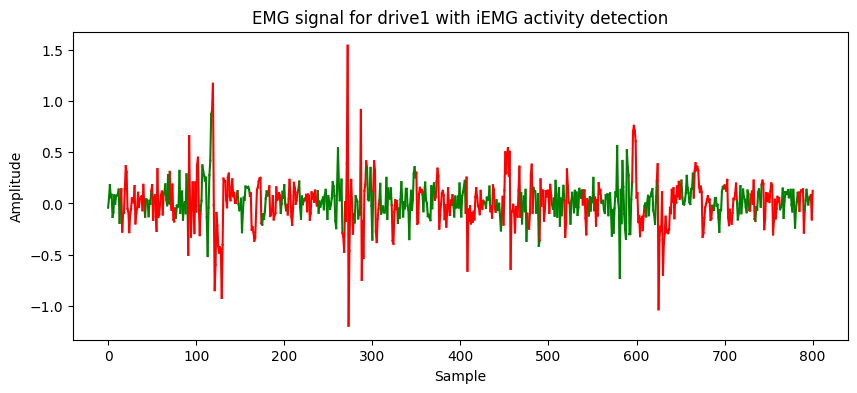

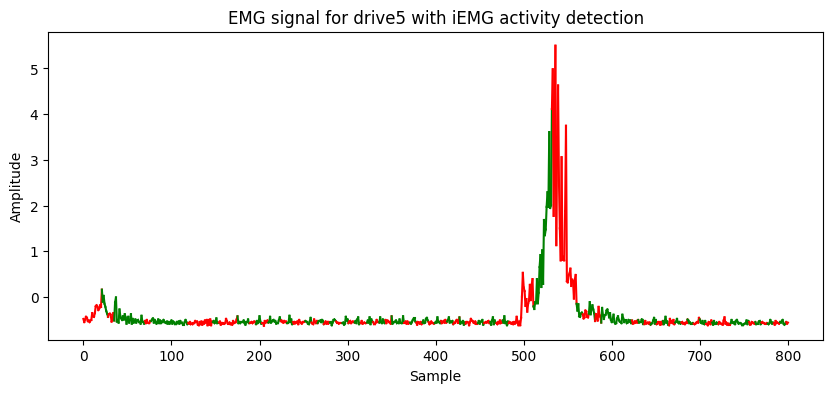

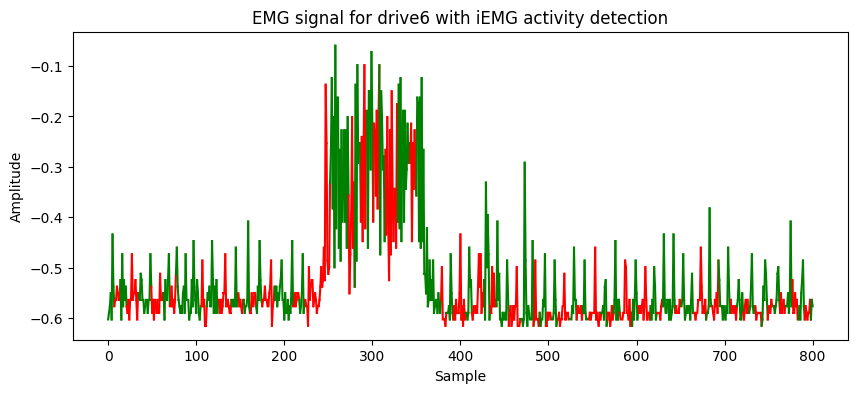

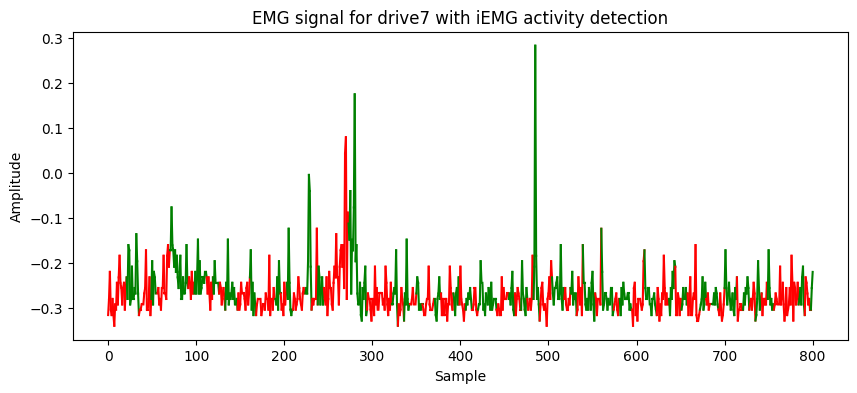

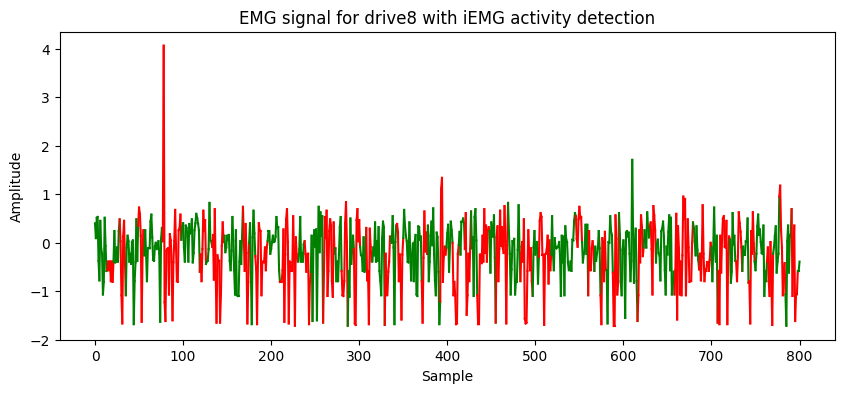

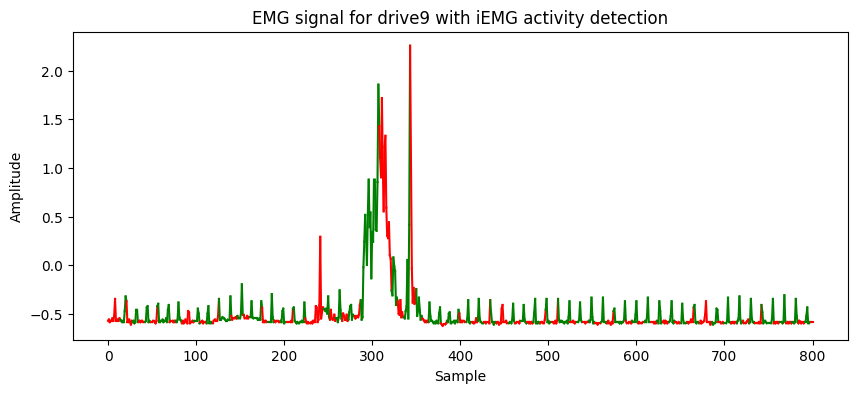

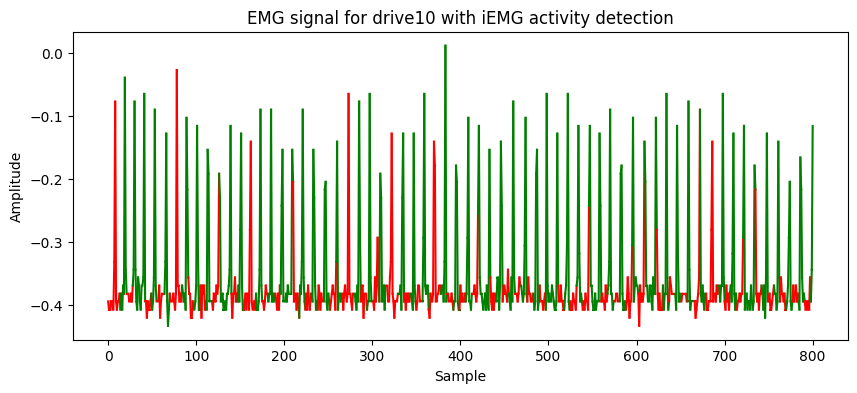

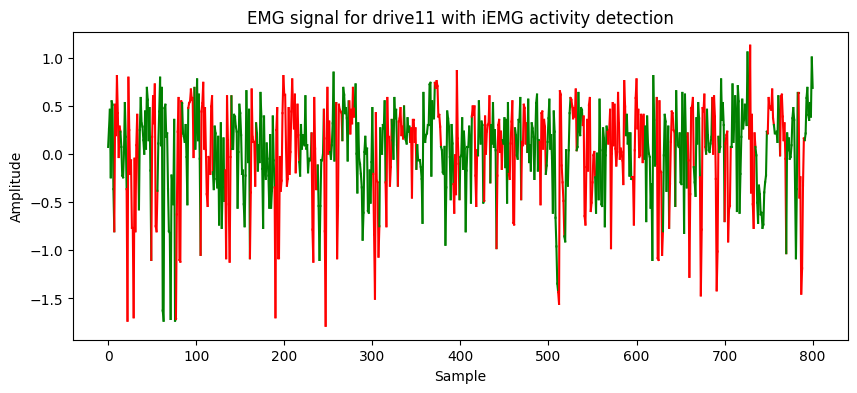

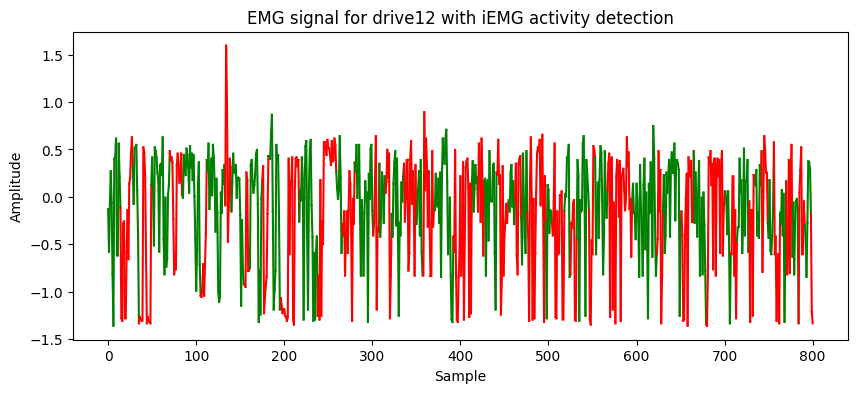

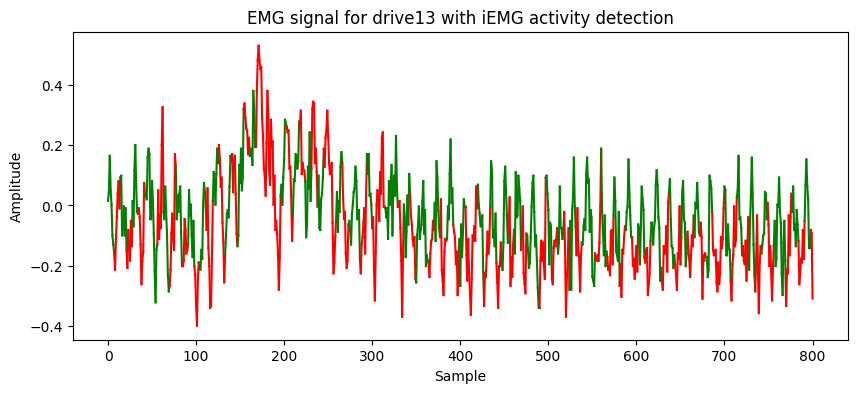

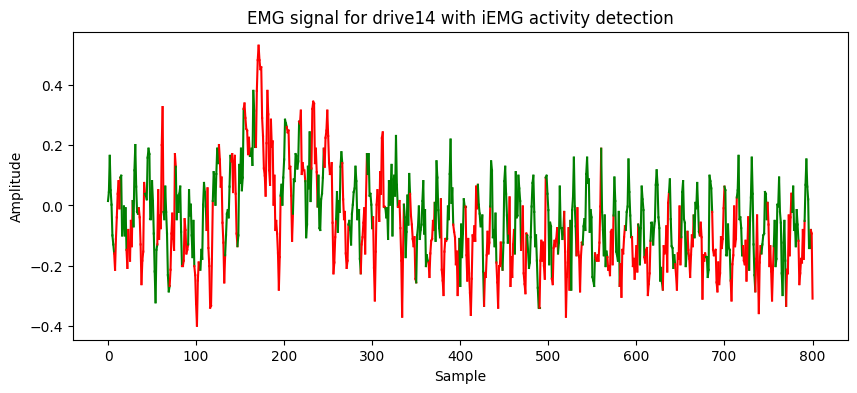

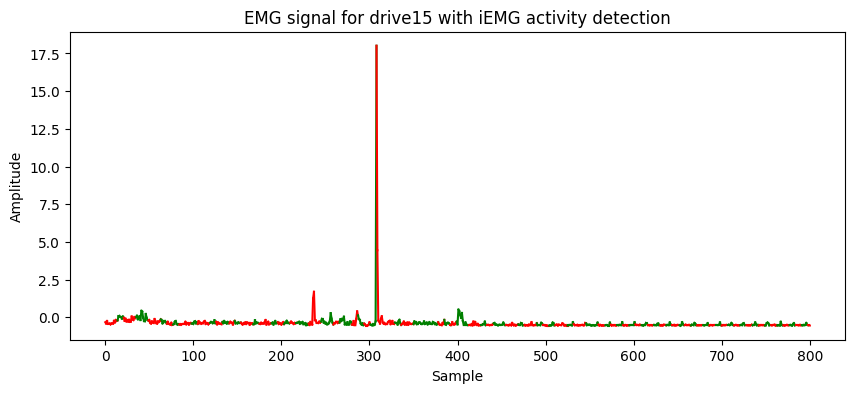

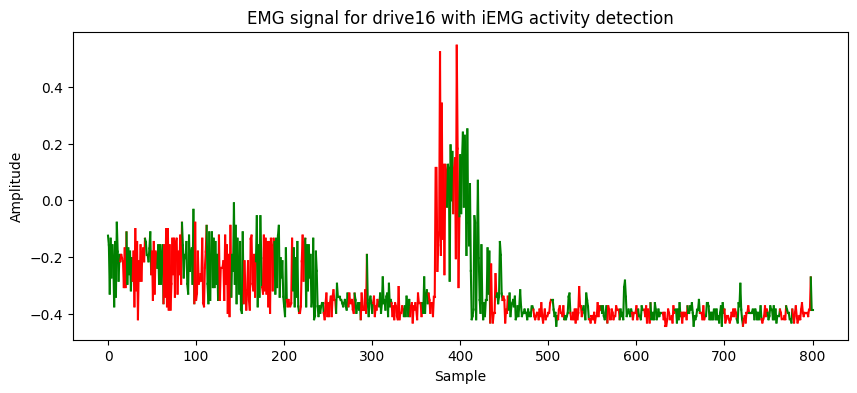

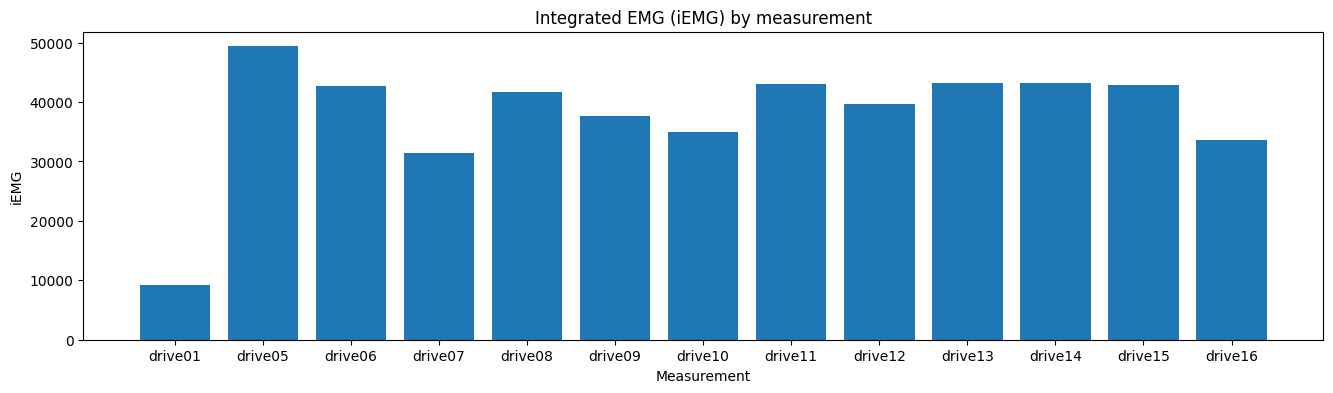

In [256]:
iEMGs = {}
measurement_names = []
for i, (emg, sr) in emgs.items():
  iEMG = np.sum(np.abs(emg))
  iEMGs[i] = iEMG

  # choose the window so the result is statistically significant
  window_size = int(sr / 2)
  windowed_iEMG = [np.sum(np.abs(emg[i:i + window_size])) for i in range(0, len(emg) - window_size, window_size)]
  iEMG_derivative = np.diff(windowed_iEMG)
 
  # Stretch the derivative to match the length of the EMG signal
  stretched_derivative = np.repeat(iEMG_derivative, window_size)
  
  # Adjust the length of stretched_derivative to match emg length by appending zeros if necessary
  if len(stretched_derivative) < len(emg):
      stretched_derivative = np.append(stretched_derivative, np.zeros(len(emg) - len(stretched_derivative)))
  
  start = 0
  end = 800

  # Plot
  plt.figure(figsize=(10, 4))
  
  # EMG signal - we'll color it in the loop below
  for sample in range(start, min(end, len(emg)-1)):
      color = 'green' if stretched_derivative[sample] > 0 else 'red'
      plt.plot([sample, sample+1], [emg[sample], emg[sample+1]], color=color)
  
  # Windowed iEMG (for reference, optional)
  # plt.plot(np.repeat(windowed_iEMG, window_size)[:end], label="Windowed iEMG", alpha=0.5)
  
  plt.title(f"EMG signal for drive{i} with iEMG activity detection")
  plt.xlabel("Sample")
  plt.ylabel("Amplitude")
  # legend that green is positive and red is negative
  plt.show()

  measurement_names.append(f'drive{"0" if i < 10 else ""}{i}')

# plot the iEMG values
plt.figure(figsize=(16, 4))
plt.bar(measurement_names, iEMGs.values())
plt.title("Integrated EMG (iEMG) by measurement")
plt.ylabel("iEMG")
plt.xlabel("Measurement")
plt.show()
